# ISY5002 PSUPR/PRMLS CA1
## Data set is sourced from https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results
## Data set label for column 5 onward are from https://github.com/kronusme/dota2-api/blob/master/data/heroes.json

The objectives is to predict if a game will win given the type of heroes picked by both teams from a pool of 113 possible heroes to choose from.
The "Won" column denotes the whether the team won (value of 1) or if the opposition team won (value of -1)
Column 5 onwards represent the heroes that could be picked, each team will pick 5 heroes with value of 1 representing hero picked by the team and value of -1 for heroes picked by the opposition team. Value of zero represents heroes not picked by either teams.

##### Name: Raymond Ng Boon Cheong  
##### Student ID: A0198543R

##### Import dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

##### Read dataset from csv

In [3]:
raw_data_train = pd.read_csv('..\dataset\dota2Train.csv')
raw_data_test = pd.read_csv('..\dataset\dota2Test.csv')

In [4]:
raw_data_train.head()

,Won,Cluster ID,Game Mode,Game Type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


##### Drop label columns and other non-relevent column

In [5]:
x_train = raw_data_train.drop(["Won", "Cluster ID"], axis=1)
y_train = raw_data_train["Won"]
x_test = raw_data_test.drop(["Won", "Cluster ID"], axis=1)
y_test = raw_data_test["Won"]

In [6]:
x_train.head()

,Game Mode,Game Type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,0,0,0,1,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,0,0,0,1,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,2,0,0,0,0,0,0,-1,0,...,-1,0,0,0,0,0,0,0,0,0
4,2,3,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y_train.head()

0   -1
1    1
2    1
3    1
4   -1
Name: Won, dtype: int64

In [8]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92650 entries, 0 to 92649
Columns: 115 entries, Game Mode to Arc Warden
dtypes: int64(115)
memory usage: 81.3 MB


In [9]:
x_train.describe()

,Game Mode,Game Type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
count,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,...,92650.000000,92650.000000,92650.000000,92650.000000,92650.0,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000
mean,3.317572,2.384587,-0.001630,-0.000971,0.000691,-0.000799,-0.002008,0.003173,-0.000345,-0.003832,...,-0.001371,-0.000950,0.000885,0.000594,0.0,0.001025,0.000648,-0.000227,-0.000043,0.000896
std,2.633070,0.486833,0.402004,0.467672,0.165052,0.355393,0.329348,0.483950,0.348865,0.501760,...,0.535024,0.206112,0.283985,0.155940,0.0,0.220703,0.204166,0.168707,0.189868,0.139033
min,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


### 1st Attempt with SVM

Build a model using linear SVC with defaults hyperparameters.  
CalibratedClassifierCV is used in conjunction with LinearSVC in order to calculate predication probability

In [10]:
cal_svc = CalibratedClassifierCV(
    base_estimator=LinearSVC(random_state=42, C=1.0, max_iter=1500, verbose=False),
    method='sigmoid', cv=5)
cal_svc.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1500,
                                                multi_class='ovr', penalty='l2',
                                                random_state=42, tol=0.0001,
                                                verbose=False),
                       cv=5, method='sigmoid')

##### Prediction and show metrics

In [11]:
y_pred = cal_svc.predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[2470 2322]
 [1819 3683]]
              precision    recall  f1-score   support

          -1       0.58      0.52      0.54      4792
           1       0.61      0.67      0.64      5502

    accuracy                           0.60     10294
   macro avg       0.59      0.59      0.59     10294
weighted avg       0.60      0.60      0.60     10294



In [12]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.5977268311637848


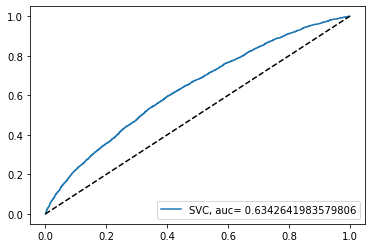

In [13]:
y_pred_proba = cal_svc.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

### 1st attempt summary

Using the LinearSVC classifier with default settings on the dataset, accuracy achieved is just 59%

### 2nd attempt

Apply preprocessing to scale the data range before training again.

In [23]:
scale_pipe = Pipeline([
    ('minmaxscale', MinMaxScaler()),
    ('cal_linsvc', CalibratedClassifierCV(
        base_estimator=LinearSVC(random_state=42, C=1.0, max_iter=1500, verbose=False),
        cv=5, method='sigmoid'))
])

In [16]:
scale_pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('minmaxscale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('cal_linsvc',
                 CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0,
                                                                 class_weight=None,
                                                                 dual=True,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 loss='squared_hinge',
                                                                 max_iter=1500,
                                                                 multi_class='ovr',
                                                                 penalty='l2',
                                                                 random_state=42,
                                                    

In [17]:
x_test_scale = MinMaxScaler().fit_transform(x_test)
y_pred = scale_pipe.predict(x_test_scale)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[1424 3368]
 [ 844 4658]]
              precision    recall  f1-score   support

          -1       0.63      0.30      0.40      4792
           1       0.58      0.85      0.69      5502

    accuracy                           0.59     10294
   macro avg       0.60      0.57      0.55     10294
weighted avg       0.60      0.59      0.56     10294



In [18]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.5908296094812512


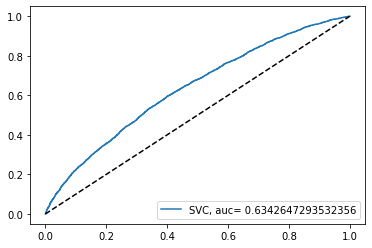

In [19]:
y_pred_proba = scale_pipe.predict_proba(x_test_scale)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

### 2nd attempt summary

Results is slightly degraded with normalization preprocessing, and accuracy remains at 59%

### 3rd attempt

As there are too many features, try to reduce dimension with PCA first.  
Use Minke's 'MLE' option to determine C value

In [31]:
pca_scale_pipe = Pipeline([
    ('minmaxscale', MinMaxScaler()),
    ('pca', PCA(n_components='mle')),
    ('cal_linsvc', CalibratedClassifierCV(
        base_estimator=LinearSVC(random_state=42, C=1.0, max_iter=1500, verbose=False),
        cv=5, method='sigmoid'))
])

In [32]:
pca_scale_pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('minmaxscale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components='mle',
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('cal_linsvc',
                 CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0,
                                                                 class_weight=None,
                                                                 dual=True,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 loss='squared_hinge',
                                                                 max_iter=1500,
                                                                 multi_class='ovr',
         

In [36]:
y_pred = pca_scale_pipe.predict(x_test_scale)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[1857 2935]
 [1241 4261]]
              precision    recall  f1-score   support

          -1       0.60      0.39      0.47      4792
           1       0.59      0.77      0.67      5502

    accuracy                           0.59     10294
   macro avg       0.60      0.58      0.57     10294
weighted avg       0.60      0.59      0.58     10294



In [37]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.5943267923061978


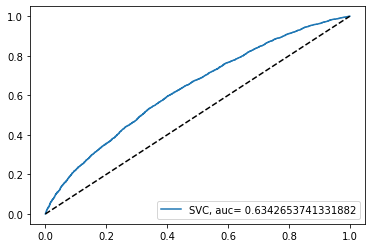

In [38]:
y_pred_proba = pca_scale_pipe.predict_proba(x_test_scale)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

### 2nd attempt summary

After applying PCA, we see accuracy drops slightly from 59.8% to 59.4%

### 3rd attempt

Drop PCA and try to tune the hyper parameter with grid search

In [61]:
params = {
    'cal_linsvc__base_estimator__loss': ('hinge', 'squared_hinge'),
    'cal_linsvc__base_estimator__C': [1.0, 10, 100],
    'cal_linsvc__base_estimator__max_iter': [1000, 3000, 5000]
}

In [64]:
gs_scale_pipe = Pipeline([
    ('minmaxscale', MinMaxScaler()),
    ('cal_linsvc', CalibratedClassifierCV(
        base_estimator=LinearSVC(random_state=42, verbose=True),
        cv=5, method='sigmoid'))
])
gs = GridSearchCV(gs_scale_pipe, param_grid=params, n_jobs=4, cv=10)

In [ ]:
gs_scale_svc = gs.fit(x_train, y_train)

In [49]:
bestParam = gs_scale_svc.calibrated_classifiers_[0].base_estimator.best_params_
bestEstimator = gs_scale_svc.calibrated_classifiers_[0].base_estimator.best_estimator_
print("Best set of parameters:")
print(bestParam)

NameError: name 'cal_svc_norm' is not defined

In [ ]:
y_pred = bestEstimator.predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

In [ ]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

In [ ]:
y_pred_proba = gs_scale_svc.calibrated_classifiers_[0].predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

### 3rd attempt summary

### 4th attempt

Use OveVsRestClassifier

In [47]:
# param_grid = dict(estimator__estimator__C = [0.01, 0.05, 0.1, 0.5, 1.0, 5, 10, 15, 20],
#                  estimator__estimator__max_iter = [500, 1000, 5000, 10000],
#                  estimator__estimator__class_weight= ('balanced', 'auto'))

In [48]:
# svr = OneVsRestClassifier(
#     BaggingClassifier(
#         CalibratedClassifierCV(
#             base_estimator=LinearSVC(
#                 random_state=42, 
#                 class_weight='balanced', 
#                 verbose=False, 
#                 fit_intercept='False',
#                 C=100,
#                 max_iter=1000),
#         method='isotonic', cv=15)
#     ), n_jobs=-1
# )
    
# gs = GridSearchCV(svr, param_grid, n_jobs=-1, verbose=2, cv=15)

In [49]:
# svr.fit(x_train_norm, y_train)

In [50]:
# y_pred = gs.predict(x_test)
# print(metrics.confusion_matrix(y_test, y_pred))
# print(metrics.classification_report(y_test, y_pred))

In [51]:
# print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

In [52]:
# y_pred_proba = gs.predict_proba(x_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plt.plot(fpr, tpr, label="SVC, auc= " + str(auc))
# plt.plot([0,1],[0,1],'k--')
# plt.legend(loc=4)
# plt.show()

In [10]:
N_FEATURES_OPTIONS = [2, 3, 4, 5, 6, 7, 8, 9, 10]
C_OPTIONS = [0.1, 1, 10, 100, 1000]
MAX_ITER_OPTIONS = [1000, 5000, 10000, 50000]

In [27]:
pipe = Pipeline([
    ('pca', PCA(iterated_power=9)),
    ('svm', SVC(random_state=42, verbose=False, kernel='linear', probability=True))
])

param_grid = [
    {
        'pca__n_components': N_FEATURES_OPTIONS,
        'svm__C': C_OPTIONS,
        'svm__max_iter': MAX_ITER_OPTIONS
    }
]

In [28]:
grid = GridSearchCV(pipe, cv=10, n_jobs=-1, param_grid=param_grid)

In [ ]:
grid.fit(x_train_norm, y_train)

In [ ]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
print(mean_scores)